In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import IPython
import IPython.display
import matplotlib as mpl
import pandas as pd
import seaborn as sns

path = "./data/all_data.csv"
df = pd.read_csv(path)

In [3]:
df.head()

,Unnamed: 0,Perimetre,Nature,Date,Heures,y,Thermique,Nucleaire,Eolien,Solaire,Hydraulique,Pompage,Bioenergies,Ech. physiques
0,0,Ile-de-France,Donn�es d�finitives,2016-01-01,00:00,8885.0,293.0,-,18.0,0.0,10.0,-,137.0,8428.0
1,1,Ile-de-France,Donn�es d�finitives,2016-01-01,00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Ile-de-France,Donn�es d�finitives,2016-01-01,00:30,8709.0,309.0,-,16.0,0.0,10.0,-,148.0,8226.0
3,3,Ile-de-France,Donn�es d�finitives,2016-01-01,00:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Ile-de-France,Donn�es d�finitives,2016-01-01,01:00,8343.0,309.0,-,13.0,0.0,10.0,-,149.0,7864.0


In [4]:
df_cons = df[["y"]]
df_cons = df_cons.dropna()
df_cons.head()

,y
0,8885.0
2,8709.0
4,8343.0
6,8041.0
8,7758.0


Train, validation, test split

In [5]:
# column_indices = {name: i for i, name in enumerate(df_cons.columns)}

n = len(df_cons)
train_df = df_cons[0:int(n*0.7)]
val_df = df_cons[int(n*0.7):int(n*0.9)]
test_df = df_cons[int(n*0.9):]

num_features = 1

Normalising the data

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

WindowGenerator class to handle data windowing
<p>The main features of the input windows are:

* The width (number of time steps) of the input and label windows.
* The time offset between them.
* Which features are used as inputs, labels, or both.

![Data windowing](data/data_windowing.png "Data Windowing Example").

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [9]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [10]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [11]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['y'])
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [12]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [13]:
def plot(self, model=None, plot_col='y', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

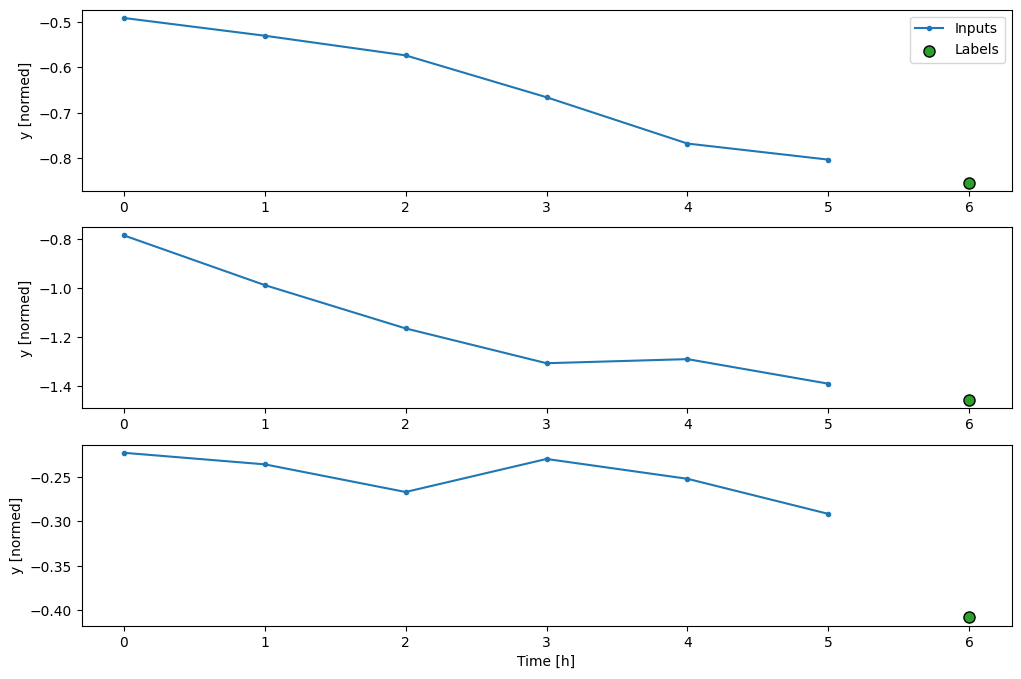

In [14]:
w2.plot()

Creating single step window for single step predictions

In [15]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['y'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['y']

In [16]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


Linear model (Basic mmodel)

In [17]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [18]:
history = compile_and_fit(linear, single_step_window)

val_performance = {}
performance = {}

val_performance['Linear'] = linear.evaluate(single_step_window.val,return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test,return_dict=True)

Epoch 1/20
1919/1919 [==============================] - 6s 3ms/step - loss: 0.7015 - root_mean_squared_error: 0.8375 - val_loss: 0.0573 - val_root_mean_squared_error: 0.2393
Epoch 2/20
1919/1919 [==============================] - 5s 2ms/step - loss: 0.0204 - root_mean_squared_error: 0.1430 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 3/20
1919/1919 [==============================] - 4s 2ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 4/20
1919/1919 [==============================] - 4s 2ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 5/20
1919/1919 [==============================] - 5s 2ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 6/20
1919/1919 [==============================] - 4s 2ms/step - loss: 0.0138 - root_mean_squared_error: 0.1177 - val_loss: 0

In [19]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['y'])

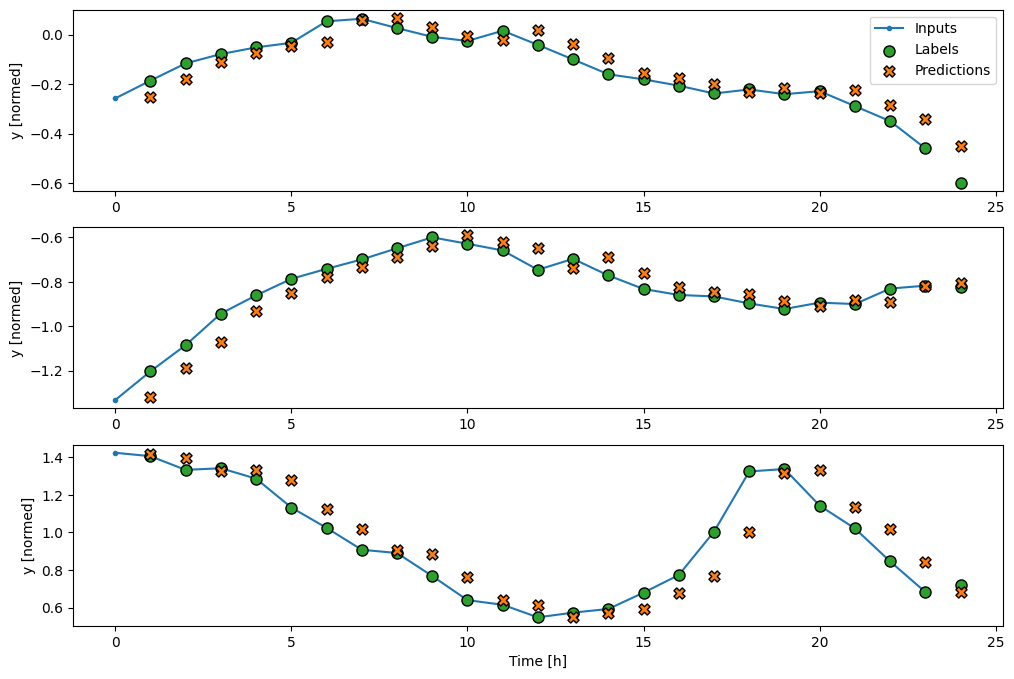

In [20]:
wide_window.plot(linear)

WindowGenerator to produce 7 inputs and 1 label

In [21]:
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['y'])

conv_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['y']

Creating a multi step dense model

In [22]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [23]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Dense'] = multi_step_dense.evaluate(conv_window.val,return_dict=True)
performance['Dense'] = multi_step_dense.evaluate(conv_window.test,return_dict=True)

274/274 [==============================] - 0s 2ms/step - loss: 0.0033 - root_mean_squared_error: 0.0572


Disadvatage that the input has to be exactly of this shape (ie. 7 input 1 label)

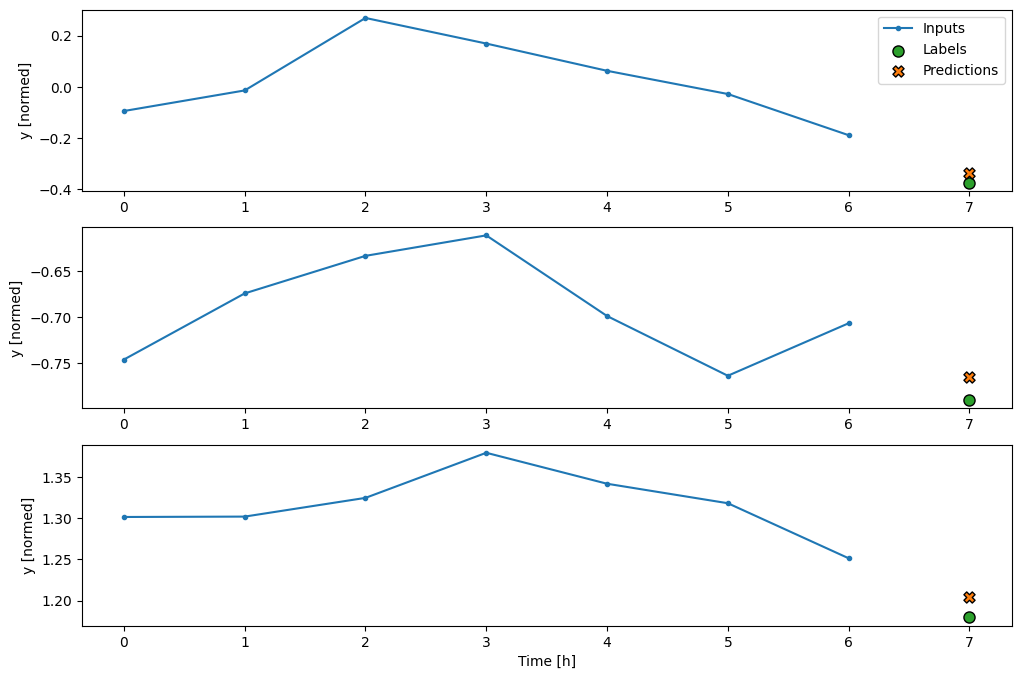

In [24]:
conv_window.plot(multi_step_dense)

Convolutional Neural Network

The following models will resolve the restriction of thee input needing to be of a certain shape

In [43]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [44]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Convolutional'] = conv_model.evaluate(conv_window.val,return_dict=True)
performance['Convolutional'] = conv_model.evaluate(conv_window.test, verbose=0,return_dict=True)

548/548 [==============================] - 1s 2ms/step - loss: 0.0056 - root_mean_squared_error: 0.0746


Since the output is shorter than the input, need the labels and predictions to be of the same length 

In [45]:
LABEL_WIDTH = 50
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['y'])

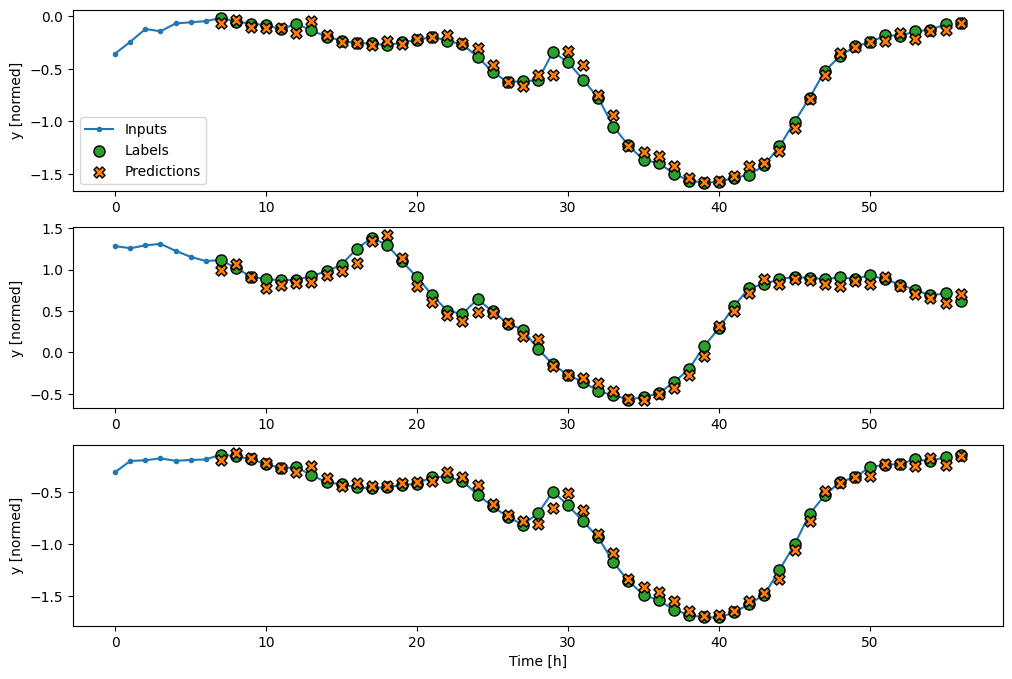

In [46]:
wide_conv_window.plot(conv_model)

Recurrent Neural Network

if return_sequences is set to False(default), layer only returns the output of the final time step

else if return_sequences is set to True, the layer returns an output for each input. This is useful for Stacking RNN layers and Training a model on multiple time steps simultaneously.

In [47]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [48]:
wide_RNN_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['y'])

In [49]:
history = compile_and_fit(lstm_model, wide_RNN_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val,return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test,return_dict=True)

274/274 [==============================] - 1s 4ms/step - loss: 0.0031 - root_mean_squared_error: 0.0560


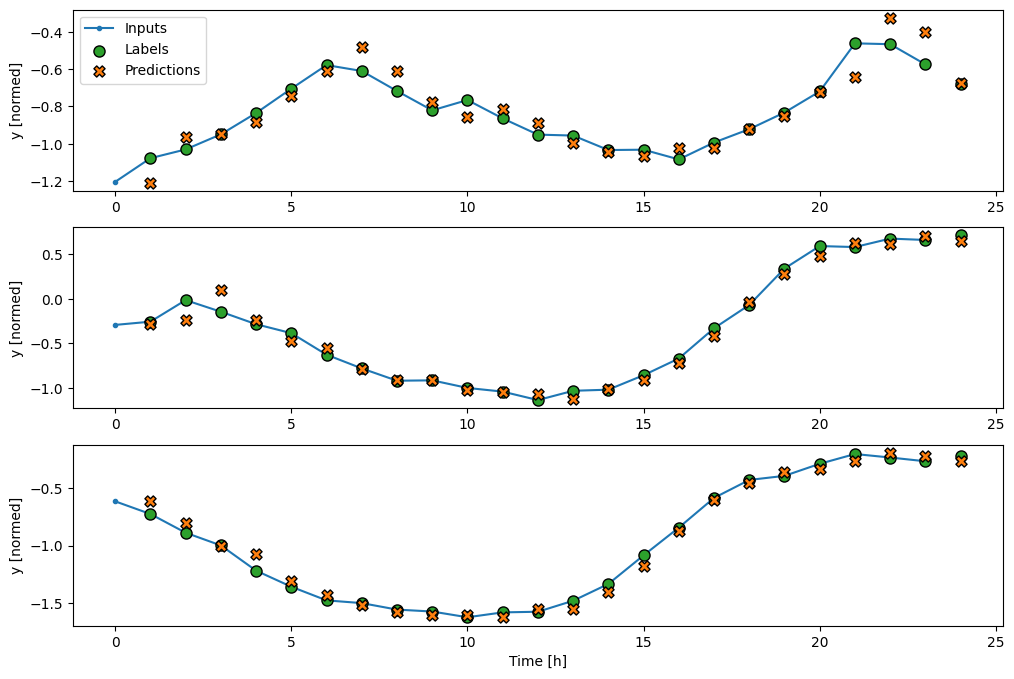

In [50]:
wide_RNN_window.plot(lstm_model)

In [51]:
performance

{'Linear': {'loss': 0.010211484506726265,
  'root_mean_squared_error': 0.10105188935995102},
 'Dense': {'loss': 0.003273899434134364,
  'root_mean_squared_error': 0.057218000292778015},
 'Convolutional': {'loss': 0.004682654049247503,
  'root_mean_squared_error': 0.06842991709709167},
 'LSTM': {'loss': 0.0031367868650704622,
  'root_mean_squared_error': 0.056007031351327896}}

In [52]:
val_performance

{'Linear': {'loss': 0.011216610670089722,
  'root_mean_squared_error': 0.10590849816799164},
 'Dense': {'loss': 0.003649552119895816,
  'root_mean_squared_error': 0.06041152402758598},
 'Convolutional': {'loss': 0.005561729893088341,
  'root_mean_squared_error': 0.07457700371742249},
 'LSTM': {'loss': 0.0033446860034018755,
  'root_mean_squared_error': 0.0578332357108593}}

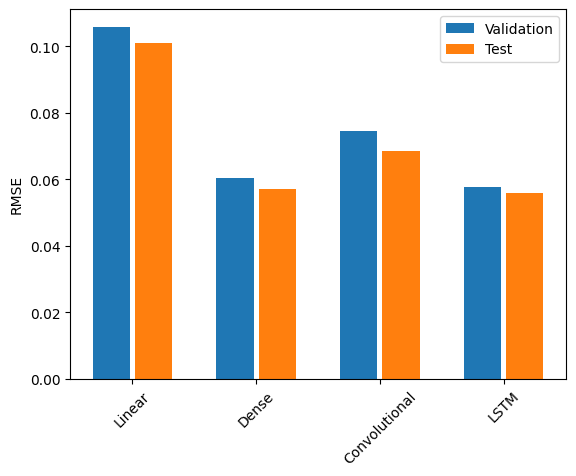

In [53]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'root_mean_squared_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'RMSE')
_ = plt.legend()

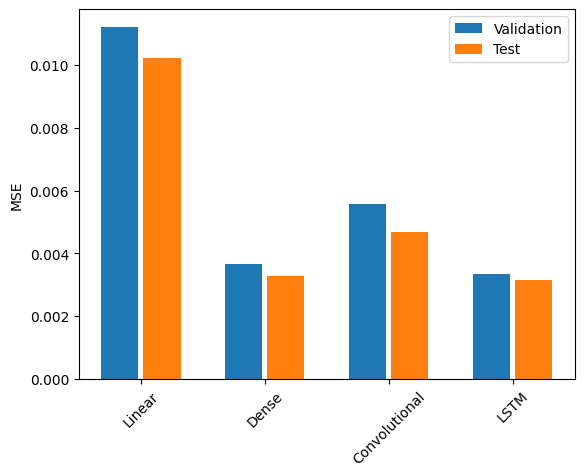

In [55]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'loss'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MSE')
_ = plt.legend()